# Modelo Homogeneo 


<p style='text-align: justify'> Se llevará a cabo la simulación de una pelicula de polietileno de alta densidad Alathon H 5618 el cual continen una nanocarga de 5% en peso de abosrbedores de oxígeno. Para realizar eta simulacion se asumirá que la nanocarga esta lo suficientemente bien distribuida en la película que se puede aproximar el comportamiento de esta a un medio continuo reactivo. En este caso se considerara que el transporte de oxigeno en el polietileno estara gobernado por la difusion y la reaccion de este en el medio.

<p style='text-align: justify'> En primer lugar se consideró una película de dimensiones 17cm x 6cm x 0.026cm, la cual tiene un peso aproximado de 13.3g y posee una carga de capsulas de 5% en peso, lo que corresponde a 0.66g de nanocapsulas. Estas a su vez, poseen un 43.37% en peso de aceite de linaza por lo cual cada pelicula contendría aproximadamente 0.29g de dicho aceite. Este dato de la cantidad de aceite en una de las películas activas es necesario para calcular la concentracion incial de los componente activos del aceite en el medio y asi poder hacer uso de la aproximación de película reactiva.</p> 

<p style='text-align: justify'> Previemente, se determinó que la concentracion inicial de los sustratos , hidrperoxidos y radicales en el aceite de linaza utilizado, asi mismo, se sabe que el aceite de linaza a temperatura ambiente posee una densidad de 931 $kg/m^3$  por lo cual se puede determinar el volumen total de aceite en una pelicula reactiva, el cual será de $3.115x10^{-7}m^3$. Con este volumen se recalcula la concentración inicial de sustrato y de hidroperóxidos en la pelicula multiplicando las concentraciones iniciales de estos por el volumen de aceite en la pelicula y diviendo el valor resultante entre el volumen total de la película el cual corresponde a $2.652x10^{-6}m^3$. Realizando el procedimiento descrito se determina que la concentración inicial de sustrato,los hidroperoxidos y los radicales en al película es </p> 

In [2]:
import numpy as np
vol_aceite=3.115e-7 #m3
vol_pelicula=2.652e-6 #m3

ROOH_aceite=19.156 #mol/m3
ROO_aceite=8.464613122386208e-07 #mol/m3
R_aceite=2.6543738835619247e-07 #mol/m3
RH_aceite=1559.34557966 #mol/m3

ROOH_pelicula,ROO_pelicula,R_pelicula,RH_pelicula=np.asarray([ROOH_aceite,ROO_aceite,R_aceite,RH_aceite])*vol_aceite/vol_pelicula
print(r'ROOH: %g, ROO: %g, R: %g, RH: %g' %(ROOH_pelicula,ROO_pelicula,R_pelicula,RH_pelicula))

ROOH: 2.25004, ROO: 9.94241e-08, R: 3.11779e-08, RH: 183.158


<p style='text-align: justify'> Ahora se procede a simular el transporte y consumo de oxígeno en la película, para esto se asume que inicialmente la película no contiene oxígeno y que esta se encuentra expuesta por ambas caras a una atmosfera de aire con 20.6% de oxígeno en volumen. A continuacion se definen las funciones que permiten realizar la simulación </p>



In [3]:
from scipy.integrate import solve_ivp, odeint
import matplotlib.pyplot as plt

def cons_cinetica(T=298):
    R=8.314;
    return np.asarray([52691244*np.exp(-101.5e3/(R*T)),6581,572.68*np.exp(-31e3/(R*T)),2.2914e+08,10362358.9,96814085.92*np.exp(-48.4e3/(R*T))])

def Solubilidad(T=298):
    R=8.314;
    return 2.0962E-5*np.exp(-1700/(R*T)); #mol/Pa m3

def Difusividad(T=298):
    R=8.314;
    return 0.43e-4*np.exp(-36581.6/(R*T)); #m2/s

def ODE_consumo(t,C):
    C_ext=C[-1]
    C=np.reshape(C[:-1],[5,n]).transpose();
    dC=np.empty([n,5])
    
    dC[:,0]=-2*k[0]*C[:,0]**2+k[2]*C[:,1]*C[:,3];
    dC[:,1]=k[0]*C[:,0]**2+k[1]*C[:,2]*C[:,4]-k[2]*C[:,1]*C[:,3]-k[4]*C[:,2]*C[:,1]-2*k[5]*C[:,1]**2;
    dC[:,2]=k[0]*C[:,0]**2-k[1]*C[:,2]*C[:,4]+k[2]*C[:,1]*C[:,3]-2*k[3]*C[:,2]**2-k[4]*C[:,2]*C[:,1];
    dC[:,3]=-k[2]*C[:,1]*C[:,3];
    
    dC[1:-1,4]=(D/delta_x**2)*(C[2:,4]-2*C[1:-1,4]+C[:-2,4])-k[1]*C[1:-1,4]*C[1:-1,2];
    
    dC[0,4]=D*(1/(delta_x**2))*(C_ext-2*C[0,-1]+C[1,-1])-k[1]*C[0,-1]*C[0,2]*0.5;
    dC[-1,4]=D*(1/(delta_x**2))*(C[-2,-1]-2*C[-1,-1]+C_ext)-k[1]*C[-1,-1]*C[-1,2]*0.5;    
    
    dC=np.reshape(dC.T,5*n);
    
    V=(P_N2/(P-C_ext/S))*Vo
    dC_ext=2*((D*(1/(2*delta_x))*(-3*C[-1,-1]+4*C[-2,-1]-C[-3,-1])))*(A/V)*R*T*S;
        
    return np.append(dC,dC_ext)

In [4]:
#Dimensiones pelicula
grosor=0.026e-2 #[m]

#Vector de posicion discretizado
n=201
x=np.linspace(0,grosor,n)
delta_x=x[1];

#Condicones de Reaccion
T=273+20 #[K]
R=8.314 #[J/mol K]
P=74660.32 #[Pa]
P_N2=0.794*P #[Pa]

#Area Y volumen considerados
A=102e-4 #[m2]
Vo=1.2e-4 #[m3]

D=Difusividad(T)
S=Solubilidad(T)
k=cons_cinetica(T)

#Vector de inicializacion
C=np.ones([n,5])*np.asarray([ROOH_pelicula,ROO_pelicula,R_pelicula,RH_pelicula,0])
C=np.reshape(C.transpose(),5*n);
Co=P*0.206*S #[mol/m3];
C=np.append(C,Co)

#Simulacion Reaccion en el horno de vacio 
t=3600*250
sol=solve_ivp(ODE_consumo,[0,t],C,method='BDF',rtol=1e-9);

In [5]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 951
     njev: 68
      nlu: 206
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.03383052e-04, 2.06766105e-04, 1.24059663e-03,
       2.27442715e-03, 5.56695794e-03, 8.85948872e-03, 1.21520195e-02,
       1.91904073e-02, 2.62287951e-02, 3.32671828e-02, 4.03055706e-02,
       5.14179652e-02, 6.25303598e-02, 7.36427545e-02, 8.47551491e-02,
       9.25133996e-02, 1.00271650e-01, 1.08029901e-01, 1.15788151e-01,
       1.23546401e-01, 1.42341781e-01, 1.61137161e-01, 1.79932541e-01,
       1.98727921e-01, 2.24133595e-01, 2.49539269e-01, 2.74944944e-01,
       3.00350618e-01, 3.25756292e-01, 3.67061810e-01, 4.08367329e-01,
       4.49672847e-01, 4.90978366e-01, 5.32283884e-01, 5.92881396e-01,
       6.53478908e-01, 7.14076420e-01, 7.74673933e-01, 8.35271445e-01,
       9.28347444e-01, 1.02142344e+00, 1.11449944e+00, 1.20757544e+00,
       1.30065144e+00, 1.44222990e+00

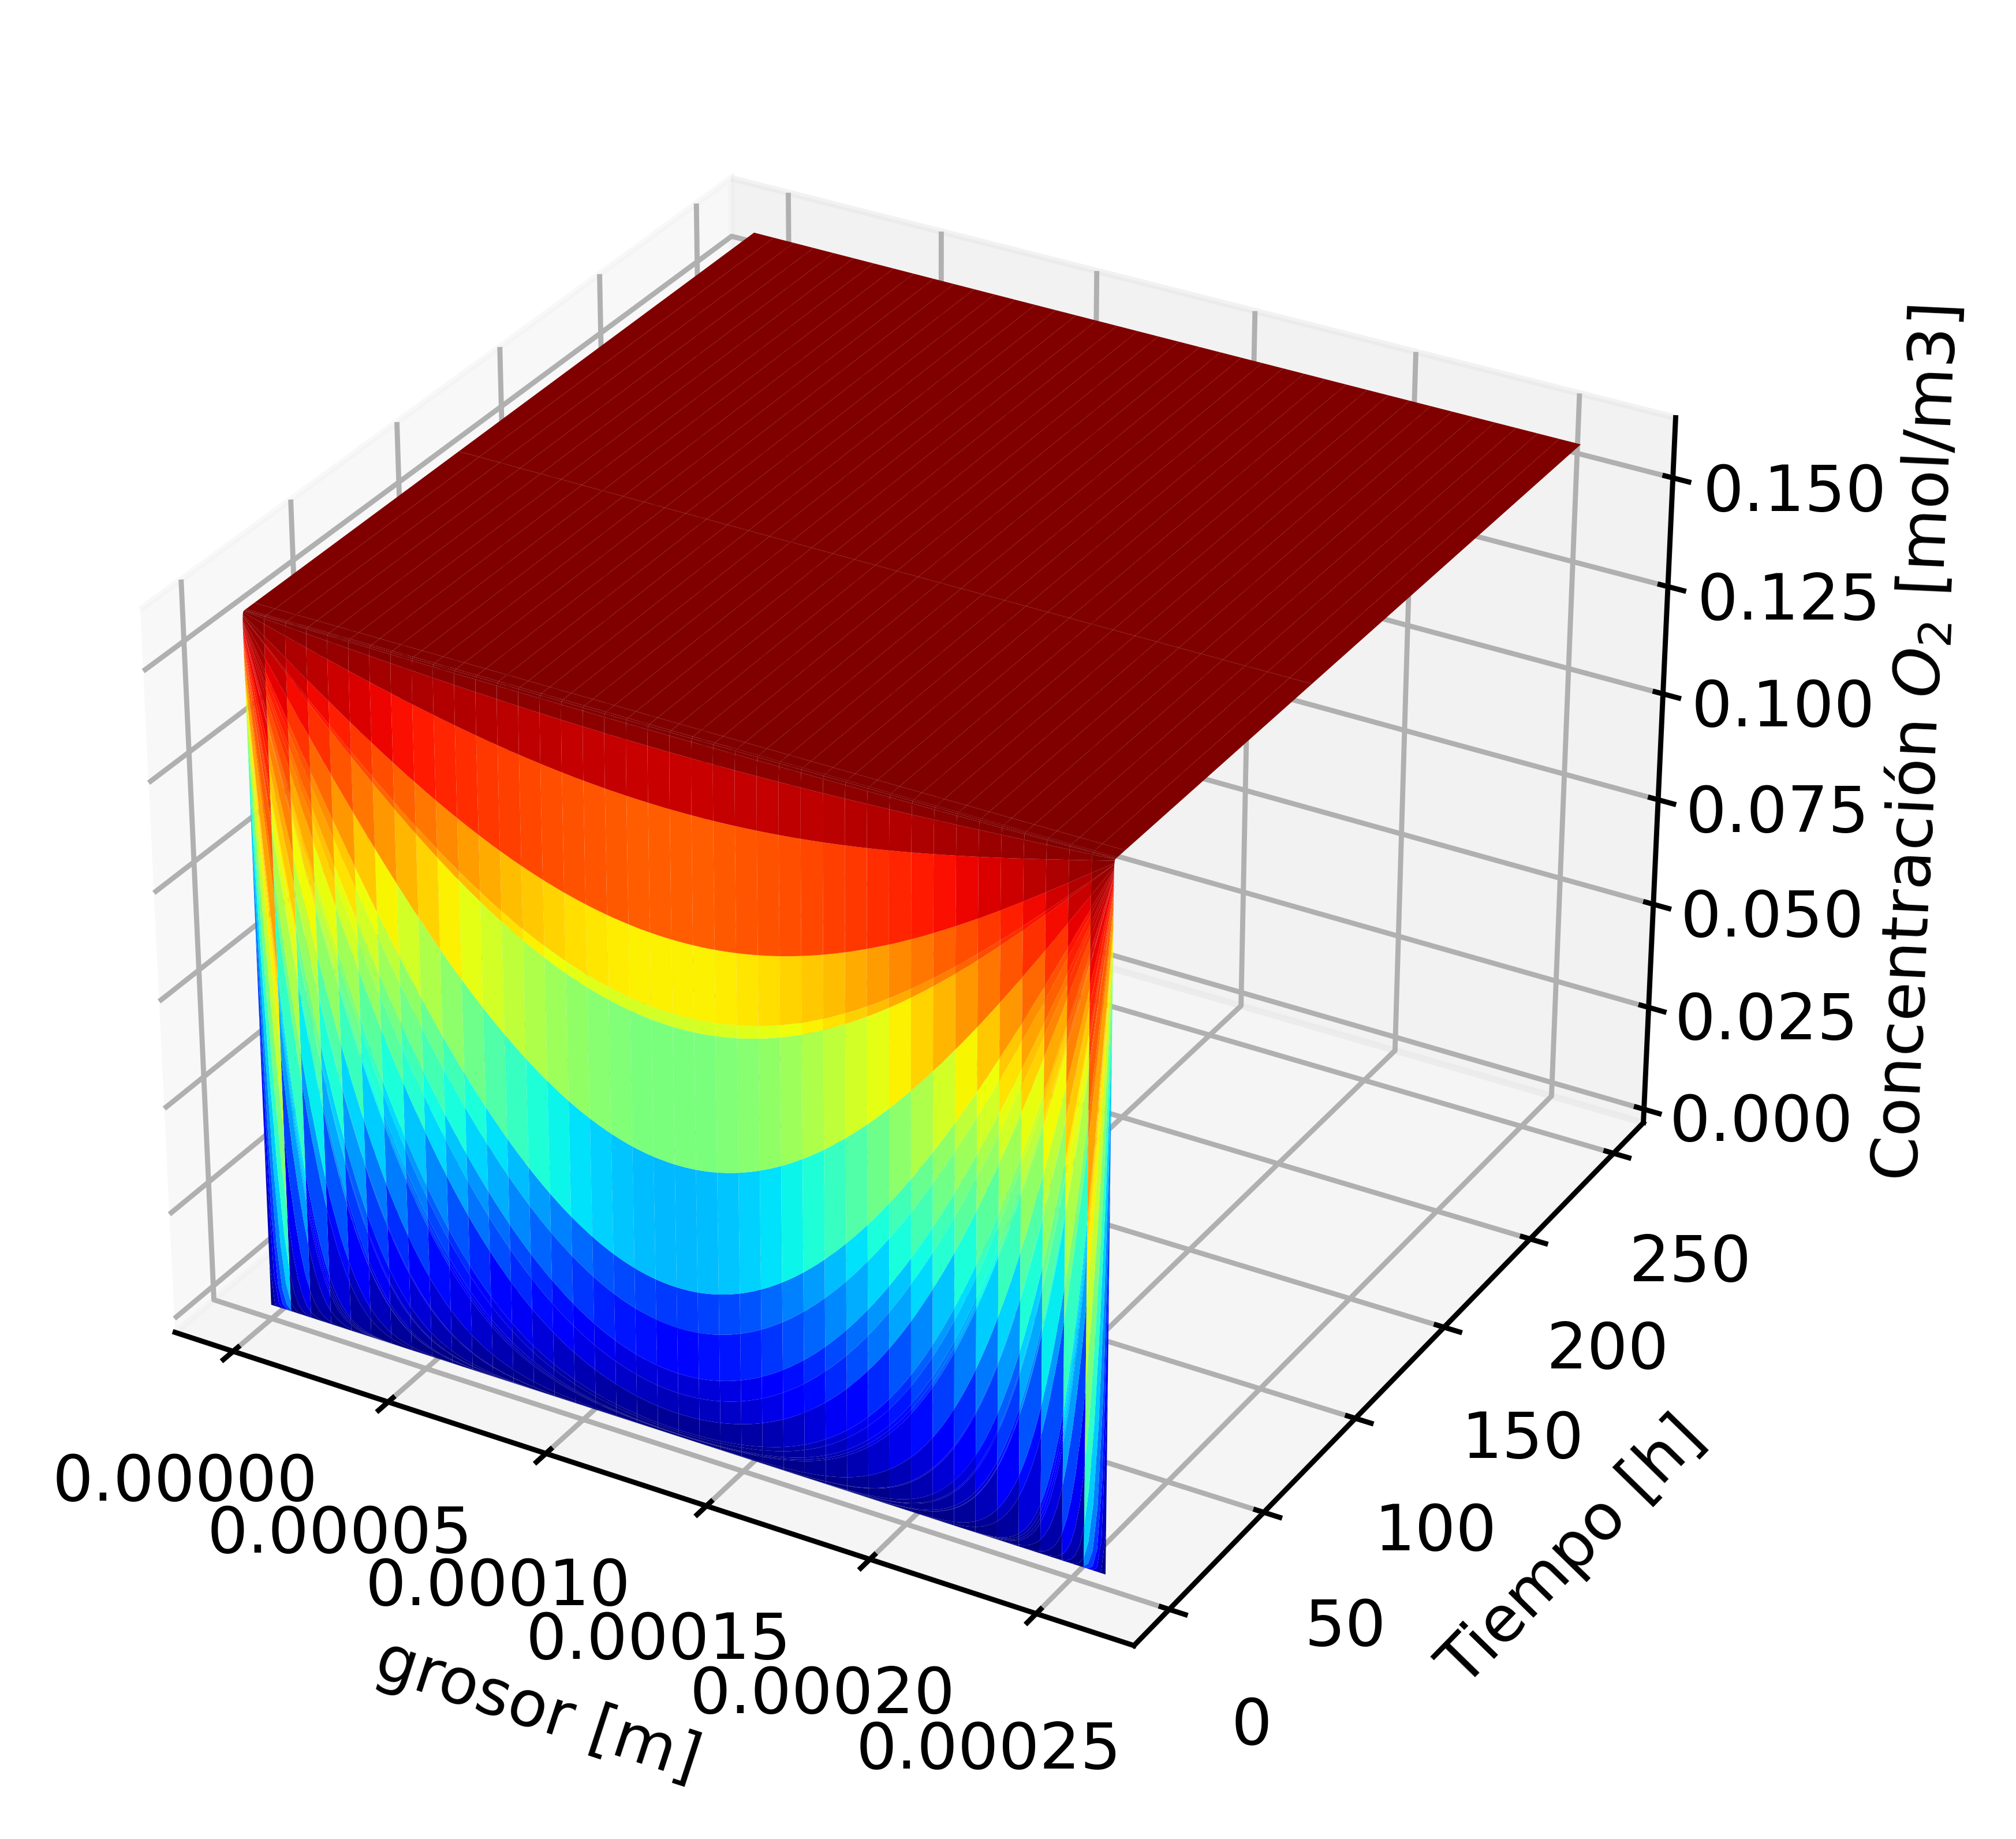

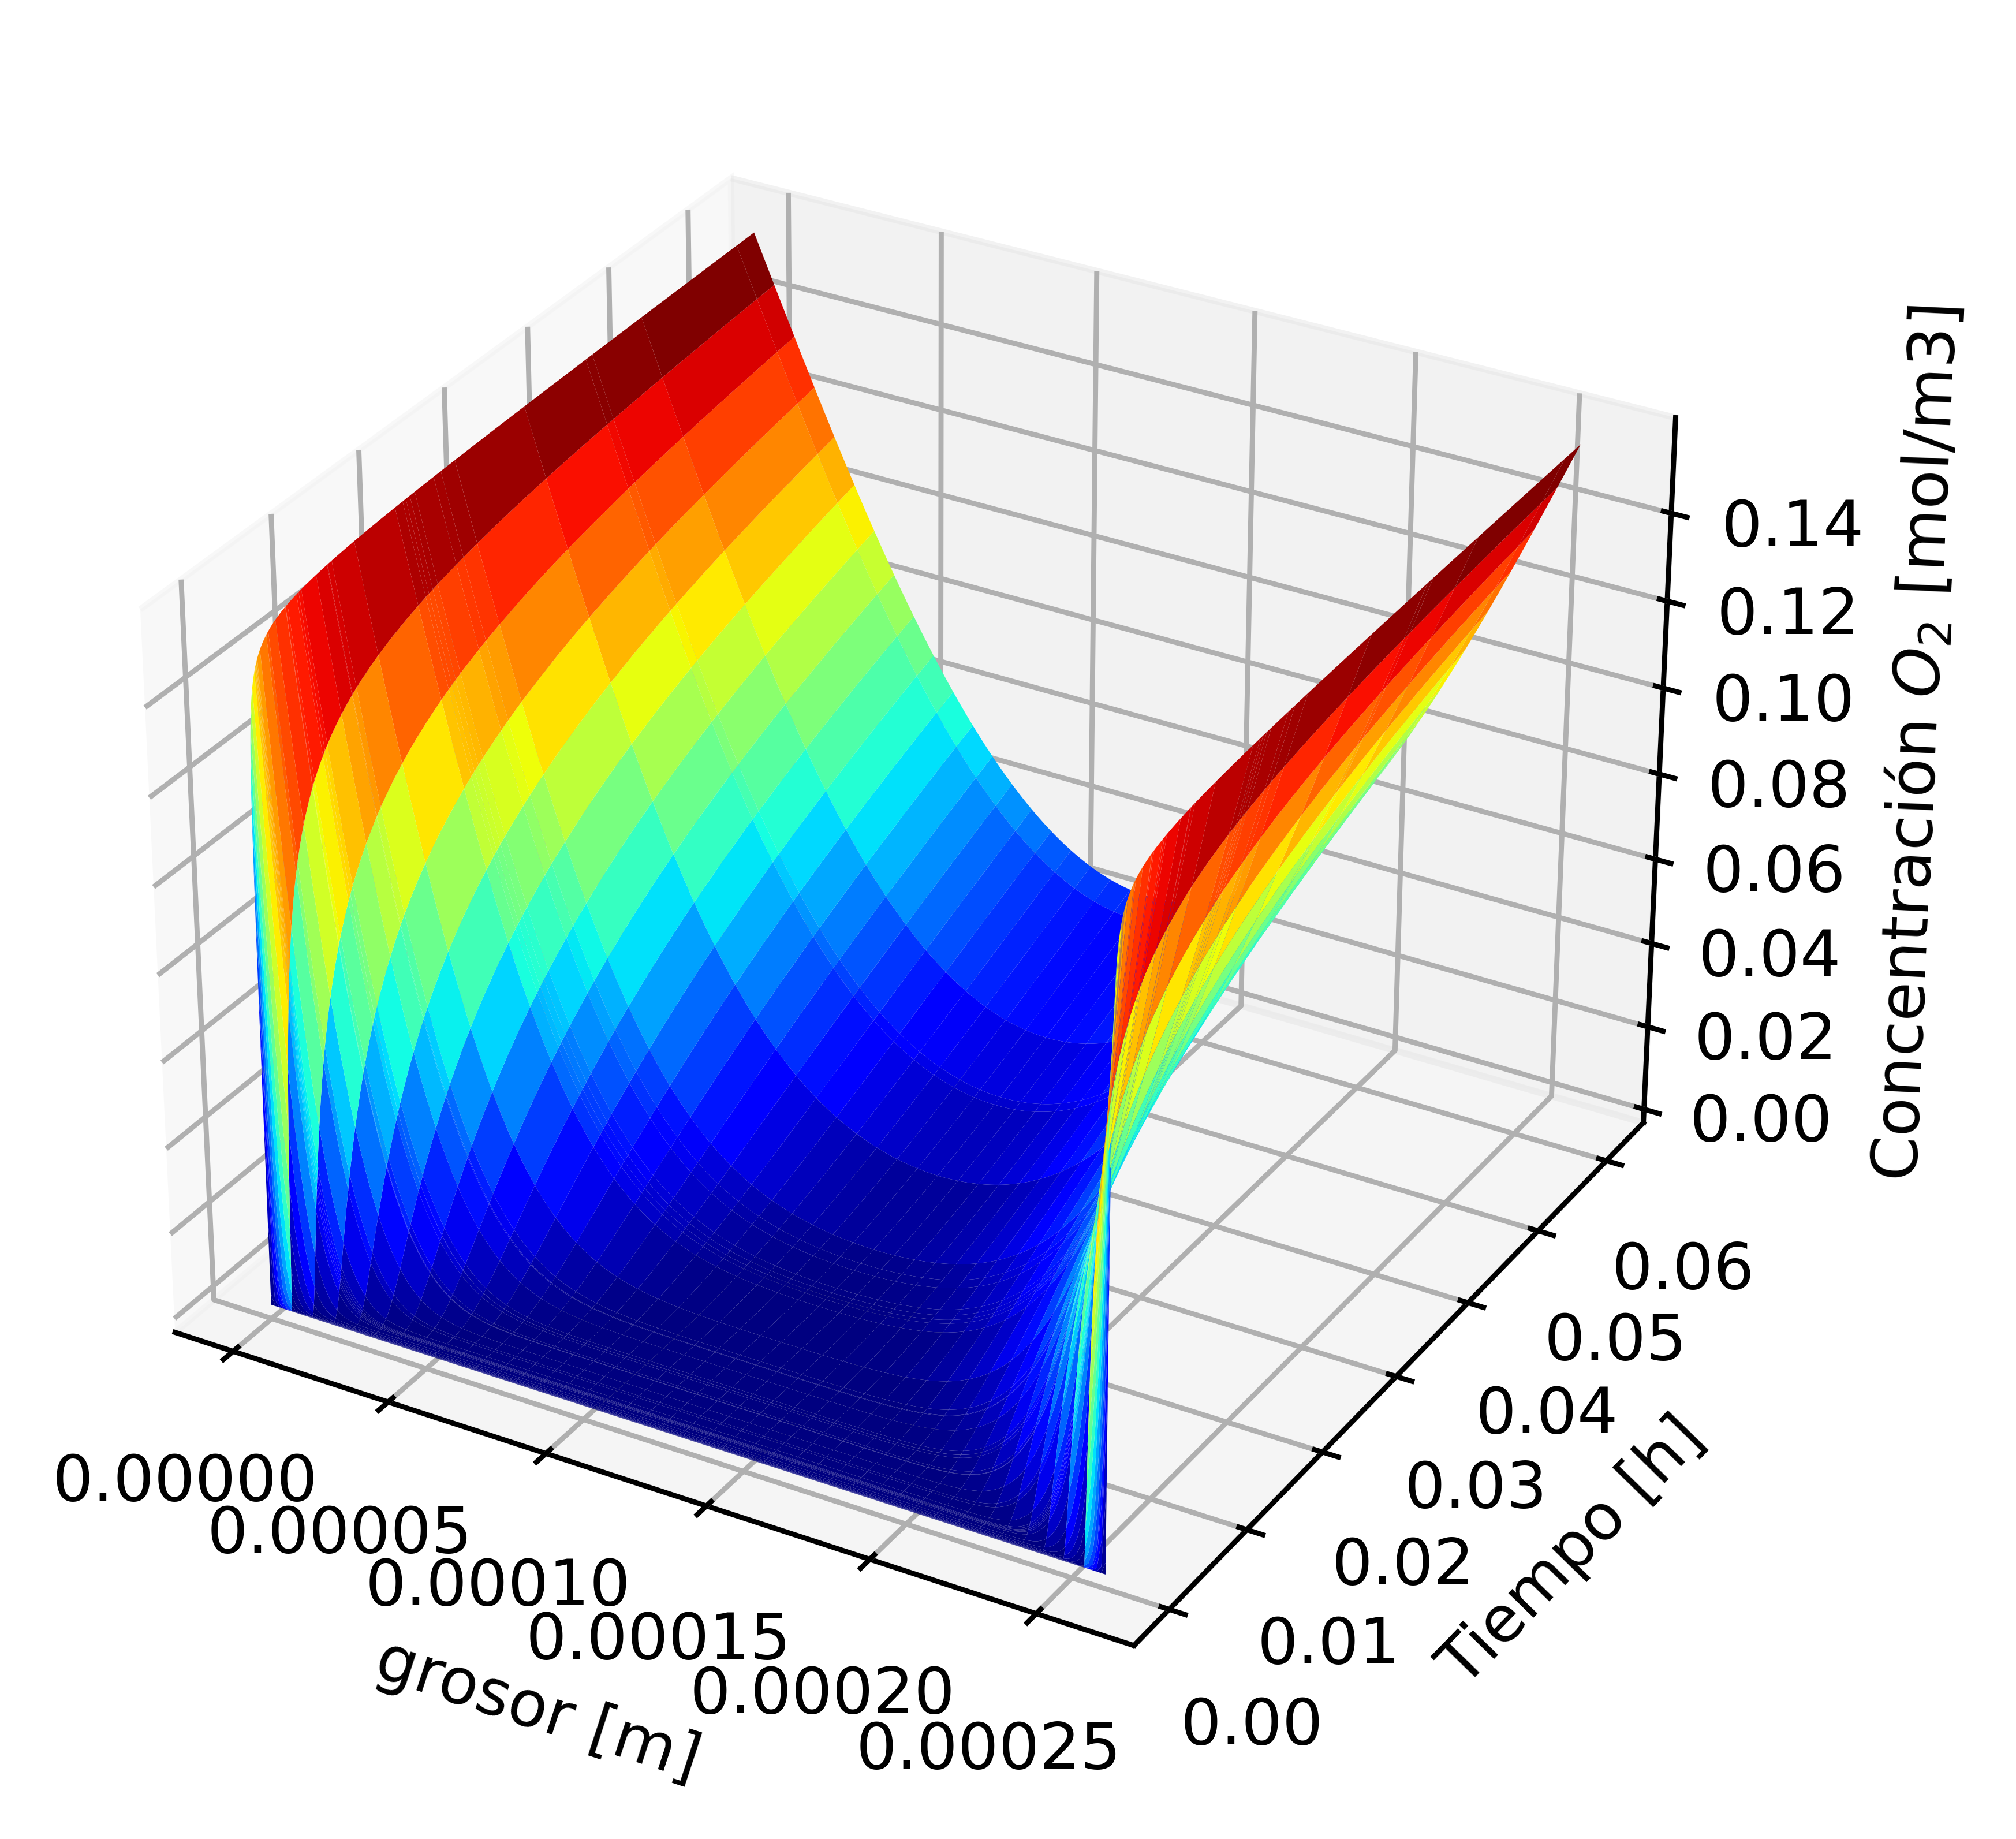

In [21]:
from mpl_toolkits.mplot3d import axes3d
plt.style.use('default')

fig = plt.figure(dpi=800,facecolor='w')
ax = fig.add_subplot(111, projection='3d')
t_T, X = np.meshgrid(sol.t[:]/3600,x[:])
ax.plot_surface(X,t_T,sol.y[4*n:5*n,],cmap='jet');
ax.set_xlabel('grosor [m]')
ax.set_zlabel('Concentración $O_2$ [mol/m3]')
ax.set_ylabel('Tiempo [h]')

fig = plt.figure(dpi=800,facecolor='w')
ax = fig.add_subplot(111, projection='3d')
t_T, X = np.meshgrid(sol.t[:200]/3600,x[:])
ax.plot_surface(X,t_T,sol.y[4*n:5*n,:200],cmap='jet');
ax.set_xlabel('grosor [m]')
ax.set_zlabel('Concentración $O_2$ [mol/m3]')
ax.set_ylabel('Tiempo [h]');

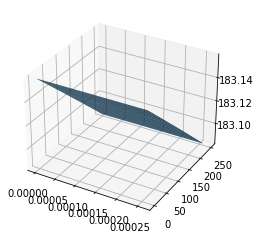

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
t_T, X = np.meshgrid(sol.t[:]/3600,x[:])
ax.plot_surface(X,t_T,sol.y[3*n:4*n,:]);

In [29]:
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

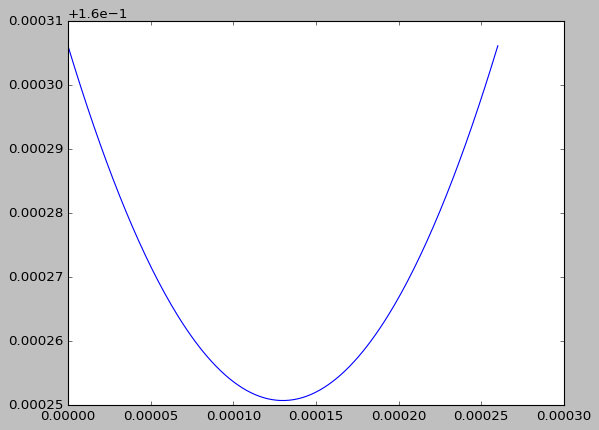

In [30]:
plt.plot(x,sol.y[4*n:5*n,-1]);

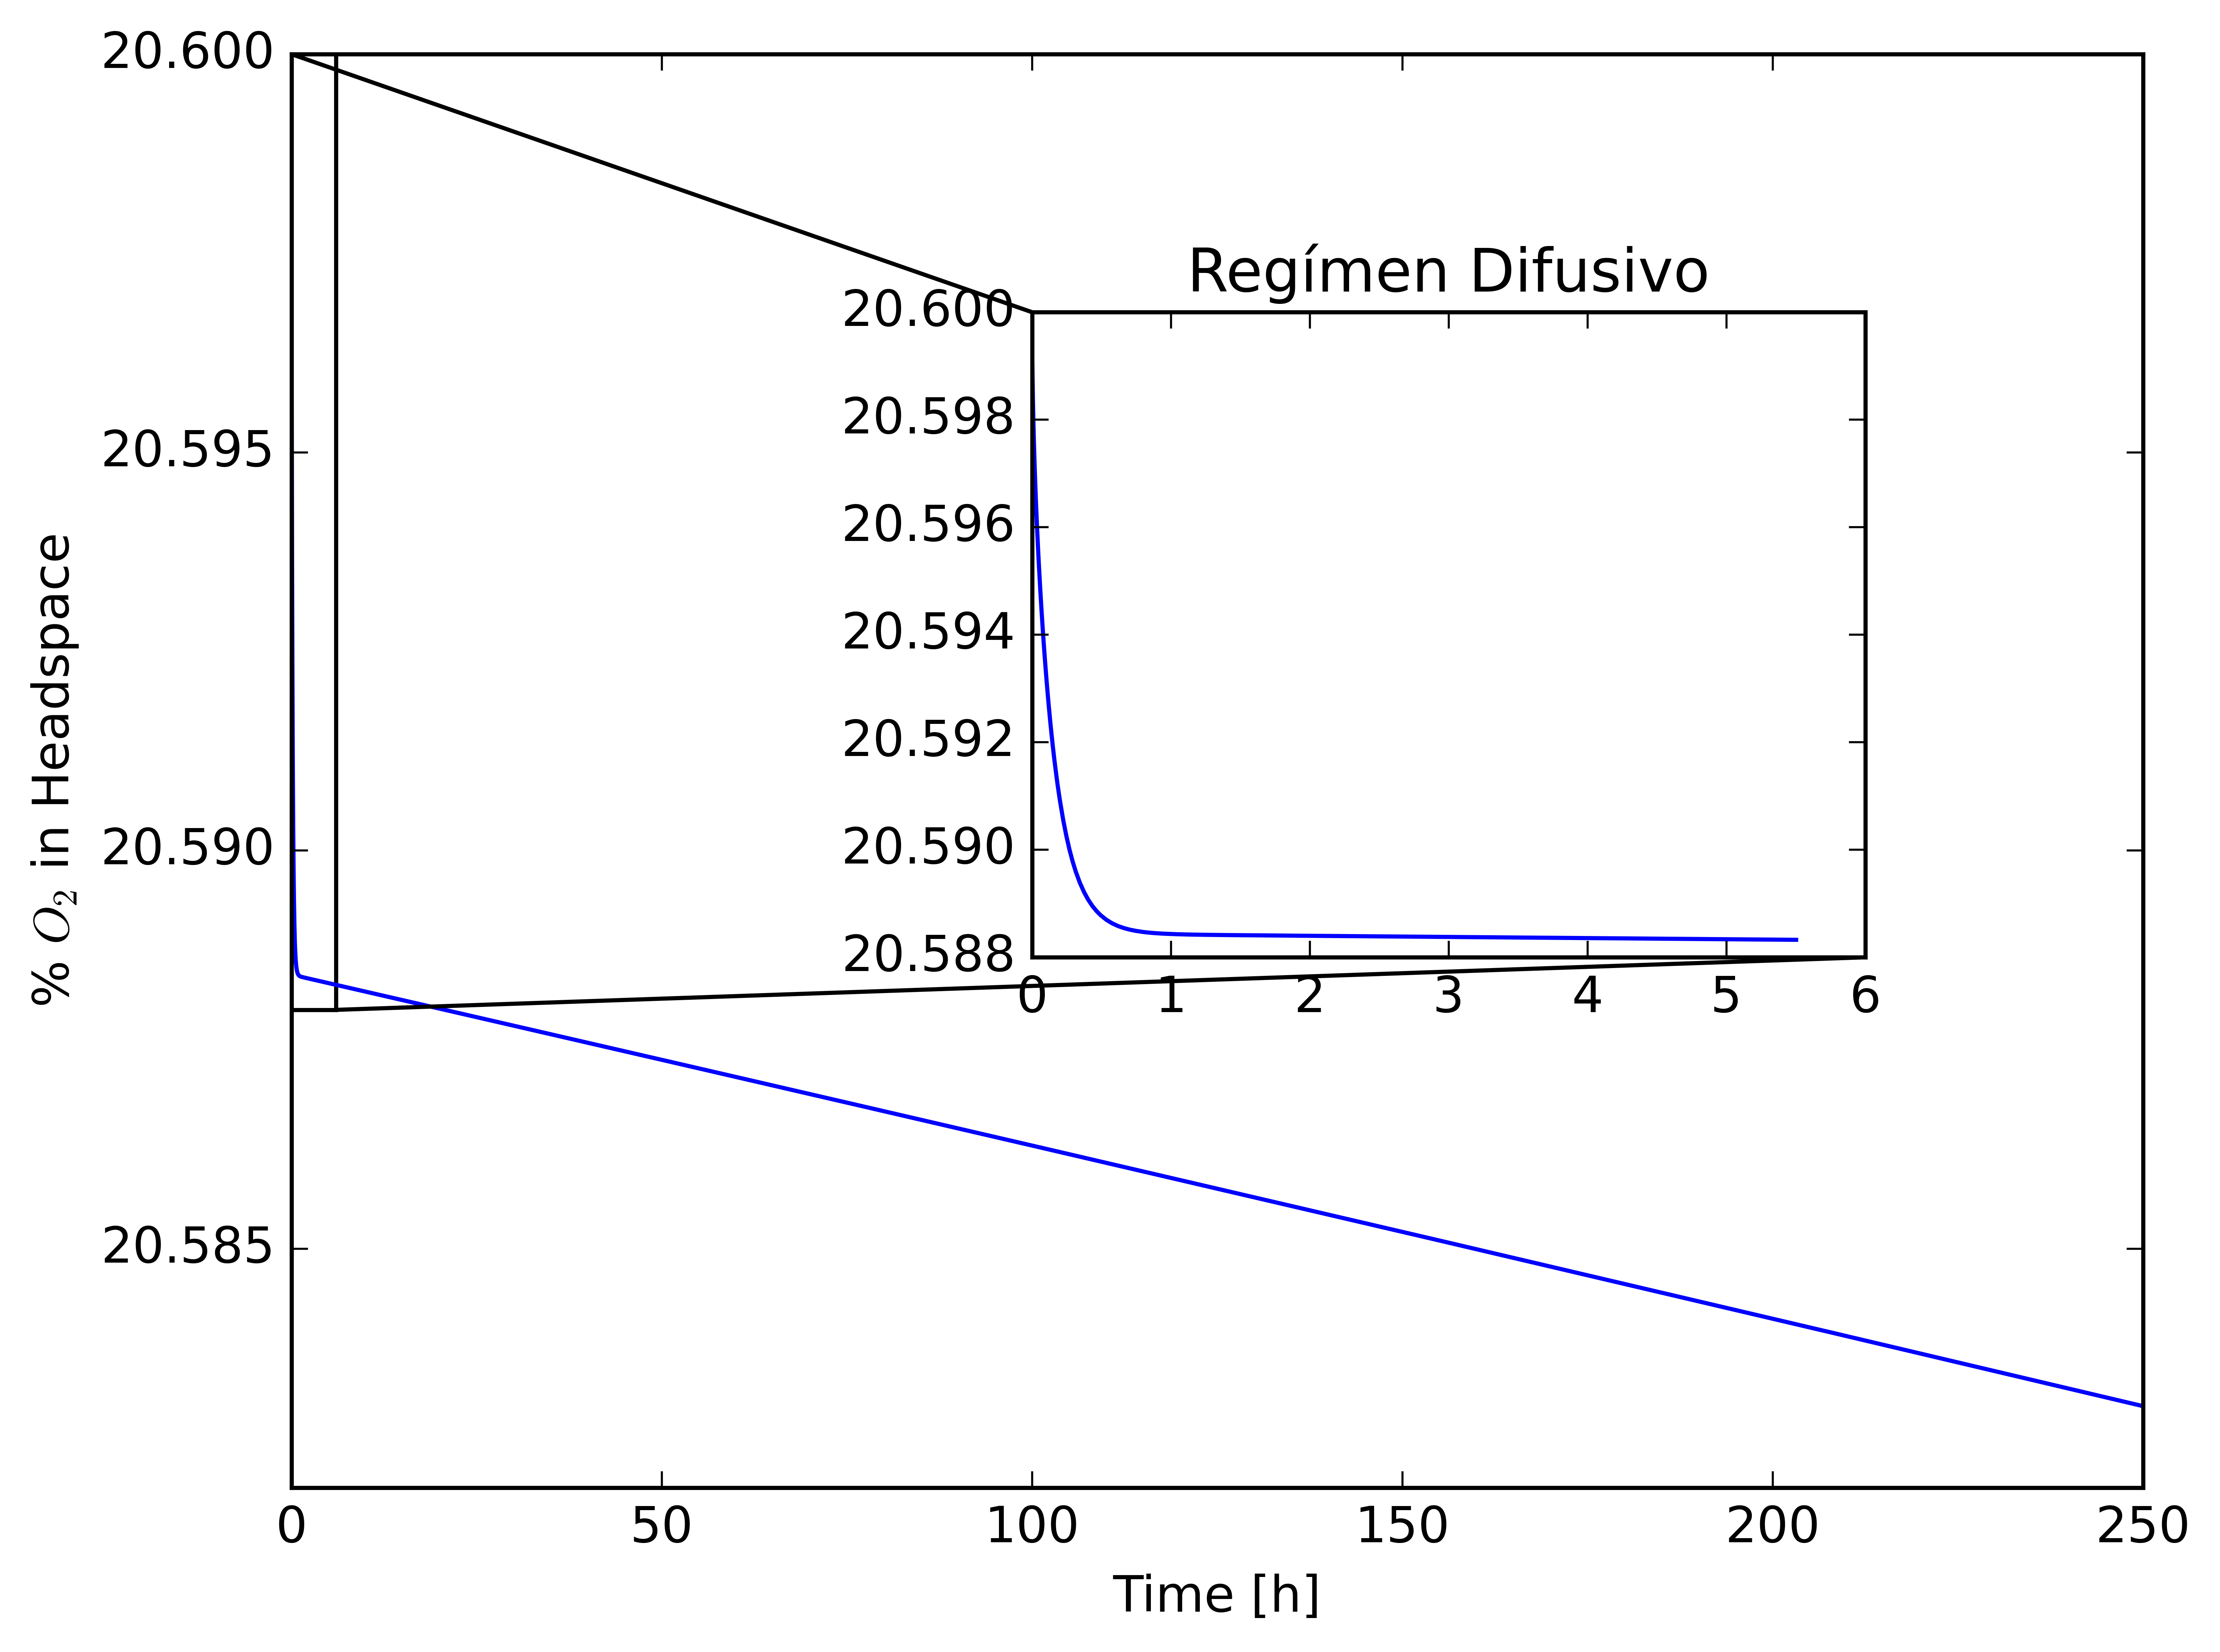

In [38]:
plt.style.use('classic')
fig,ax1=plt.subplots(dpi=800,facecolor='w')
ax1.plot(sol.t/3600,sol.y[-1,:]*100/(S*P))
ax1.ticklabel_format(axis='y',useOffset=False)
ax1.set_xlabel('Time [h]')
ax1.set_ylabel('% $O_2$ in Headspace');
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.4,0.37,0.45,0.45])
ax2.set_title(r'Regímen Difusivo')
ax2.set_axes_locator(ip)
ax2.plot(sol.t[:265]/3600,sol.y[-1,:265]*100/(S*P))
ax2.ticklabel_format(axis='y',useOffset=False)
mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='k');

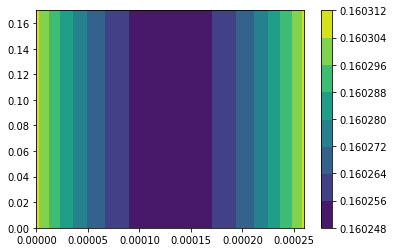

In [220]:
fig, ax = plt.subplots()
y=np.linspace(0,17e-2,101)
Y, X = np.meshgrid(y,x[:])
res=np.ones([len(y),len(x)])
res=res*sol.y[4*n:5*n,-1]
a=ax.contourf(X,Y,res.T)
plt.colorbar(a)

In [213]:
res[:,-2]

array([8.44966544e-08, 8.44966544e-08, 8.44966544e-08, 8.44966544e-08,
       8.44966544e-08, 8.44966544e-08, 8.44966544e-08, 8.44966544e-08,
       8.44966544e-08, 8.44966544e-08, 8.44966544e-08, 8.44966544e-08,
       8.44966544e-08, 8.44966544e-08, 8.44966544e-08, 8.44966544e-08,
       8.44966544e-08, 8.44966544e-08, 8.44966544e-08, 8.44966544e-08,
       8.44966544e-08, 8.44966544e-08, 8.44966544e-08, 8.44966544e-08,
       8.44966544e-08, 8.44966544e-08, 8.44966544e-08, 8.44966544e-08,
       8.44966544e-08, 8.44966544e-08, 8.44966544e-08, 8.44966544e-08,
       8.44966544e-08, 8.44966544e-08, 8.44966544e-08, 8.44966544e-08,
       8.44966544e-08, 8.44966544e-08, 8.44966544e-08, 8.44966544e-08,
       8.44966544e-08, 8.44966544e-08, 8.44966544e-08, 8.44966544e-08,
       8.44966544e-08, 8.44966544e-08, 8.44966544e-08, 8.44966544e-08,
       8.44966544e-08, 8.44966544e-08, 8.44966544e-08, 8.44966544e-08,
       8.44966544e-08, 8.44966544e-08, 8.44966544e-08, 8.44966544e-08,
      

In [235]:
len(sol.t)

274